In [1]:
import utils
import numpy as np
import math
import scipy
import mpmath
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
import bayesflow as bf
import tensorflow as tf
import tensorflow_probability as tfp
# Set TensorFlow to use only the CPU
tf.config.set_visible_devices([], 'GPU')

cor, pal = utils.matplotlib_style()

# Set random seed
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

/Users/mrazo/Library/Caches/pypoetry/virtualenvs/scrappy-jDg5b02t-py3.11/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Two-state promoter distribution

In this notebook, we will explore training a `BayesFlow` neural network to
perform parametric inference on the biophysical parameters of a two-state
promoter model. The two-state promoter model, also known as the "telegraph
model", is a simple model of gene expression that describes the dynamics of a
promotion region that can be in one of two states: active or inactive. The
steady mRNA distribution can be obtained by solving the master equation for the
system. The solution has a closed form and is given by:

$$
{\scriptstyle
P\left(m \mid k^{(p)}_{\text{on}}, k^{(p)}_{\text{off}}, r_m, \gamma_m\right) =
\frac{1}{\Gamma(m + 1)}
\frac{
    \Gamma
    \left(
        \frac{k^{(p)}_{\text{on}}}{\gamma_m} + m
    \right)
}{
    \Gamma
    \left(
        \frac{k^{(p)}_{\text{on}}}{\gamma_m}
    \right)
}
\frac{
    \Gamma
    \left(
        \frac{k^{(p)}_{\text{on}} + k^{(p)}_{\text{off}}}{\gamma_m}
    \right)
}{
    \Gamma
    \left(
        \frac{k^{(p)}_{\text{on}} + k^{(p)}_{\text{off}}}{\gamma_m} + m 
    \right)
}
\left( \frac{r_m}{\gamma_m} \right)^m \\
\times {}_1F_1 
\left(
    \frac{
            k^{(p)}_{\text{on}} 
        }{
            \gamma_m
        }
    + m,
    \frac{
            k^{(p)}_{\text{on}} + k^{(p)}_{\text{off}} 
        }{
            \gamma_m
        }
    + m,
    - \frac{r_m}{\gamma_m}
\right),
}
\tag{1}
$$


where $m$ is the steady-state mRNA copy number per cell, $k_{\text{on}}^{(p)}$
and $k_{\text{off}}^{(p)}$ are the rate constants for the promoter turning on
and off, respectively, $r_m$ is the mRNA production rate, and $\gamma_m$ is the
mRNA degradation rate.

The challenge to evaluate this distribution is that the confluent hypergeometric
function $_1F_1$ can be numerically unstable in certain parameter regimes. In a
separate notebook, we explored asymptotic approximations to the confluent
hypergeometric function, allowing us to tackle this problem. 



Here, we will focus
on setting up a neural network to perform inference on the parameters of the
model.

But before getting to that, let's show the steady-state mRNA distribution for
a parameter regime to make sure all functions previously-defined are working.

Text(0, 0.5, 'Probability')

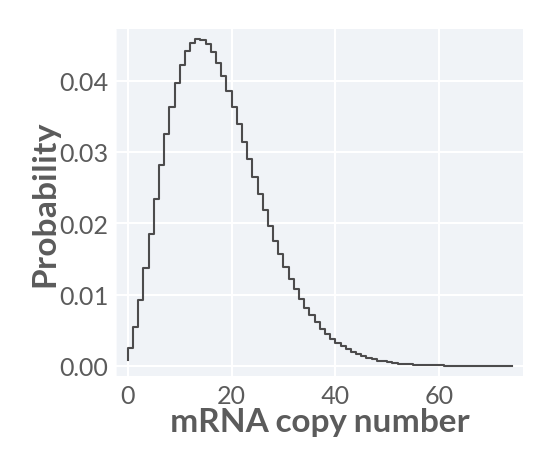

In [2]:
# Define parameters
k_on = 4.0
k_off = 18.0
r_m = 100.0

# Define range of mRNA
m_range = np.arange(0, 75)

# Evaluate the log probability
logP = utils.two_state_log_probability(m_range, k_on, k_off, r_m)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Plot the probability
ax.step(m_range, np.exp(logP))

# Label axis
ax.set_xlabel("mRNA copy number")
ax.set_ylabel("Probability")

This looks excellent. Let's try again with a more challenging parameter regime.

Text(0, 0.5, 'Probability')

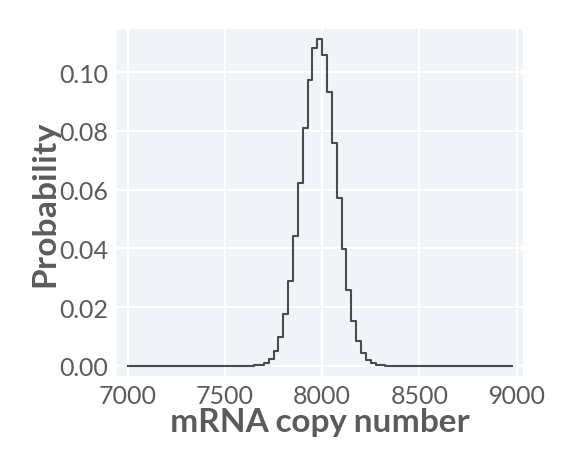

In [3]:
# Define parameters
k_on = 4.0
k_off = 2.0
r_m = 8000.0

# Define range of mRNA
m_range = np.arange(7000, 9000, 25)

# Evaluate the log probability
logP = utils.two_state_log_probability(m_range, k_on, k_off, r_m)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Plot the probability
ax.step(m_range, np.exp(logP) / np.sum(np.exp(logP)))

# Label axis
ax.set_xlabel("mRNA copy number")
ax.set_ylabel("Probability")

Again, everything looks in order. Let's now move on to setting the `BayesFlow`
neural network.

## Prior distribution function

Let's define the function that samples parameters from the prior distribution.

In [25]:
def prior_fn():
    # Prior on k_on rate
    k_on = np.abs(rng.normal(1E-4, 10))
    # Prior on k_off rate
    k_off = np.abs(rng.normal(1E-4, 10))
    # Prior on rate of transcription r
    r = 1E-3 + np.abs(10 * rng.standard_cauchy())

    return np.float32(np.array([k_on, k_off, r]))

We can now define the `BayesFlow` `simulation.Prior` object and sample from the
prior distribution.

In [26]:
# Define parameter names
param_names = ['k_on', 'k_off', 'r']

# Define prior simulator
prior = bf.simulation.Prior(
    prior_fun=prior_fn,
    param_names=param_names,
)

# Draw samples from the prior
prior(10)

{'prior_draws': array([[1.46118889e+01, 2.82596993e+00, 6.73090315e+00],
        [1.11952591e+01, 4.47823715e+00, 1.06296849e+00],
        [1.87660992e+00, 2.78153729e+00, 2.03398681e+00],
        [8.07018280e+00, 1.61986198e+01, 2.24345303e+01],
        [1.18773508e+01, 1.02061300e+01, 1.87797104e+02],
        [9.30848217e+00, 1.79760456e+01, 1.38905449e+01],
        [8.93120575e+00, 1.14612915e-01, 2.94922352e+00],
        [2.04876556e+01, 1.78517838e+01, 1.23379517e+01],
        [8.55029297e+00, 6.39636421e+00, 3.54231334e+00],
        [6.35381126e+00, 7.40024233e+00, 1.86900368e+01]], dtype=float32),
 'batchable_context': None,
 'non_batchable_context': None}

## Likelihood function

Next, we can define the likelihood function. This function takes as input the
log parameters and simulates a dataset by sampling from the likelihood function
conditioned on the parameters. The likelihood function is given by the steady
state mRNA distribution described above in Eq. (1).

### Naive likelihood function

For the first attempt, we will try to compute the likelihood function by 
evaluating the log probability of the mRNA copy number given the parameters for
a fixed range of mRNA copy numbers. After having these probabilities, we can
sample from the distribution to simulate UMI counts.

In [27]:
def likelihood_fn(params, n_obs=10_000, m_range=range(0, 2_000)):
    # Unpack parameters
    k_on, k_off, r = params
    # Compute the log probability over m_range
    logP = utils.two_state_log_probability(m_range, k_on, k_off, r)
    # Convert log probabilities to probabilities
    P = np.exp(logP)
    # Normalize the probabilities to use as weights. This is necessary because
    # of numerical precision issues.
    P /= P.sum()
    # Generate random samples using these weights
    u = np.random.choice(m_range, size=n_obs, p=P)
    # Add a 3rd dimension to the array to make output 3D tensor
    u = np.expand_dims(u, axis=1)
    # Return the samples as float32
    return np.float32(u)

Let's define the `BayesFlow` `simulation.Simulator` object and the generative
model.

In [28]:
# Define Likelihood simulator function for BayesFlow
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fn)

# Build generative model
model = bf.simulation.GenerativeModel(prior, simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Next, let's time how long it takes to simulate 10 datasets.

In [29]:
%time model_draws = model(10)

CPU times: user 1.54 s, sys: 15.2 ms, total: 1.56 s
Wall time: 1.56 s


The time varies every time we run this simulation. The precision to compute the
confluent hypergeometric function is the main factor that determines the time it
takes to simulate the data.

Let's try simulating a large number of datasets.

In [46]:
# Define the number of draws
n_draws = 100
# Draw samples from the generative model
%time model_draws = model(n_draws)

CPU times: user 22.9 s, sys: 123 ms, total: 23.1 s
Wall time: 23.1 s


Now, let's plot the simulated data ECDFs.

Text(0, 0.5, 'ECDF')

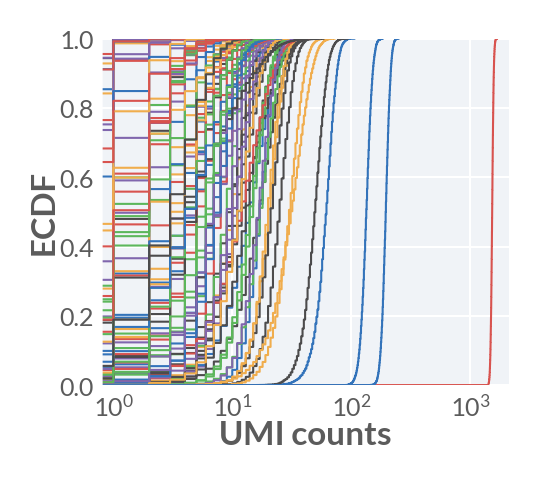

In [47]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Loop through the draws and plot the data
for m in range(n_draws):
    sns.ecdfplot(model_draws["sim_data"][m, :, :].flatten(), ax=ax)

# Set x-axis to log scale
ax.set_xscale("log")

# Label axis
ax.set_xlabel("UMI counts")
ax.set_ylabel("ECDF")

This covers a wide range of mRNA copy numbers. 

## Summary network

Next, we define the summary network. For this, we will try the `DeepSet` network
architecture.

In [51]:
# Define summary network as a Deepset
summary_net = bf.networks.DeepSet(summary_dim=8)

# Simulate a pass through the summary network
summary_pass = summary_net(model_draws["sim_data"])

summary_pass.shape

TensorShape([100, 8])

## Inference network

For the inference network, we will use the default `InvertibleNetwork`
architecture.

In [53]:
# Define the conditional invertible network with affine coupling layers
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=prior(1)["prior_draws"].shape[-1],
)

inference_net(model_draws['prior_draws'], summary_pass)

(<tf.Tensor: shape=(100, 3), dtype=float32, numpy=
 array([[1.02516918e+01, 3.54204249e+00, 1.01698704e+01],
        [1.20827284e+01, 7.02163553e+00, 2.23410301e+01],
        [8.53813827e-01, 7.22961884e+01, 1.66149483e+01],
        [5.91968822e+00, 1.02030122e+00, 9.14566231e+00],
        [1.45274754e+01, 1.40425415e+01, 4.48867607e+00],
        [8.69771194e+00, 4.97484541e+00, 4.84720755e+00],
        [7.41291761e+00, 1.03416233e+01, 9.09169579e+00],
        [8.52683067e+00, 5.32431841e+00, 2.59551764e+00],
        [3.36966681e+00, 1.54749432e+01, 8.43799973e+00],
        [1.85844576e+00, 3.19346637e-01, 1.14938688e+01],
        [9.66139698e+00, 5.28323746e+00, 3.70360613e+00],
        [1.64431171e+01, 3.14048004e+01, 8.76554871e+00],
        [1.09217234e+01, 3.28661346e+01, 3.30529523e+00],
        [3.95152807e+00, 1.24457645e+00, 2.74942532e+01],
        [8.18487644e+00, 1.83832569e+01, 1.08146048e+01],
        [3.77182865e+00, 1.17791100e+01, 1.91680584e+01],
        [2.10994072e+

## Training the model

Now we are ready to put everything together and train the model.

First, we define the `BayesFlow` `amortizer`.

In [54]:
# Assemble the amoratizer that combines the summary network and inference
# network
amortizer = bf.amortizers.AmortizedPosterior(
    inference_net, summary_net,
)

Next, we set the `trainer`.

In [55]:
# Assemble the trainer with the amortizer and generative model
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Now, we can train the model.

In [56]:
# Define the number of epochs
n_epoch = 10
# Define the number of iterations per epoch
n_iter = 100
# Define the batch size
batch_size = 128
# Define number of validation simulations
n_val = 200

# Train the model
history = trainer.train_online(
    epochs=n_epoch,
    iterations_per_epoch=n_iter,
    batch_size=batch_size,
    validation_sims=n_val,
)